In [1]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import binarize
import pickle
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from mapseq_fxns import sort_by_celltype
# from math import log10
from scipy import stats

# random sample consimment between runs
import random

# import multiple t-tests
from statsmodels.sandbox.stats.multicomp import multipletests



%matplotlib inline

In [3]:
# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/'
out_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/output/'

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import purple_cmp, green_cmp, blue_cmp, orange_cmp

#### load data
with open(in_path +'M194_M220_OMC_bin4.pkl', 'rb') as f:
    omc_bin = pickle.load(f)

In [4]:
# seperate by cell type

omc_type = [sort_by_celltype(omc_bin[i]) for i in range(num_samples)]
omc_pt = [(omc_type[i][omc_type[i]['type']==1000]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]
omc_it = [(omc_type[i][omc_type[i]['type']==10]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]

omc_mm = []
omc_st = []
omc_pt_mm = []
omc_pt_st = []
omc_it_mm = []
omc_it_st = []
mice_mm=[]
mice_st=[]

for i in range(num_samples):
    if metadata.species[i] == 'Mmus':
        omc_mm.append(omc_type[i])
        omc_pt_mm.append(omc_pt[i])
        omc_it_mm.append(omc_it[i])
        mice_mm.append(mice[i])
    else:
        omc_st.append(omc_type[i])
        omc_pt_st.append(omc_pt[i])
        omc_it_st.append(omc_it[i])
        mice_st.append(mice[i])

omc_mm_all = pd.concat(omc_mm)
omc_st_all = pd.concat(omc_st)

In [5]:
def clean_up_data(df_dirty):
    # drop unused areas
    to_drop = ['OB', 'ACAi', 'ACAc', 'HIP']
    dropped = df_dirty.drop(to_drop, axis=1)

    # change RN to bs
    replaced = dropped.rename(columns={'RN':'BS'})

    return replaced


In [6]:
for i in range(len(omc_it_mm)):
    omc_it_mm[i] = clean_up_data(omc_it_mm[i])

for i in range(len(omc_pt_mm)):
    omc_pt_mm[i] = clean_up_data(omc_pt_mm[i])

for i in range(len(omc_it_st)):
    omc_it_st[i] = clean_up_data(omc_it_st[i])

for i in range(len(omc_pt_st)):
    omc_pt_st[i] = clean_up_data(omc_pt_st[i])

In [8]:
omc_it_mm[0]

,OMCi,OMCc,AUD,STR,TH,HY,AMY,SNr,SCm,PG,PAG,BS
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8334,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8335,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8336,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Node degree by cell type

In [ ]:
def df_to_nodes(df_list, drop = ["OMCi", "type"], mice=None, species=None):
    """
    Function to turn list of binarized dataframes per animal to dataframe 
    containing node proportions

    df_list = list of binarized dataframes
    drop = list of column names to drop
    mice = list of mouse names
    species = string of species name
    returns dataframe of node proportions
    """

    nodes_list = []
    for i in range(len(df_list)):
        if drop == []:
            int_df = df_list[i]
        else:
            int_df = df_list[i].drop(drop, axis=1)
        nodes = int_df.sum(axis=1)
        node_counts = nodes.value_counts().sort_index()
        node_proportion = node_counts/node_counts.sum()
        df_save = pd.DataFrame(node_proportion, columns=["Normalized Frequency"]).reset_index(names="Node Degree")
        df_save["Species"] = species
        df_save["mouse"] = mice[i]
        nodes_list.append(df_save)

    node_all = pd.concat(nodes_list)

    return node_all


In [10]:
mm_it_nodes = df_to_nodes(omc_it_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
st_it_nodes = df_to_nodes(omc_it_st, drop=["OMCi"], mice=mice_st, species="STeg")
mm_pt_nodes = df_to_nodes(omc_pt_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
st_pt_nodes = df_to_nodes(omc_pt_st, drop=["OMCi"], mice=mice_st, species="STeg")

Text(0.5, 1.0, 'IT Cells')

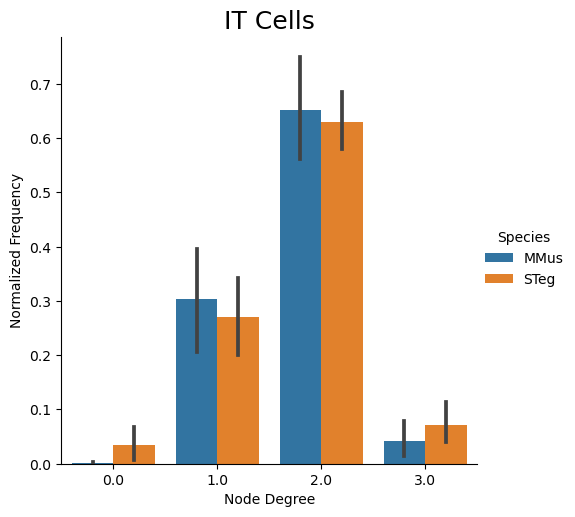

In [13]:
plot = pd.concat([mm_it_nodes, st_it_nodes])
sns.catplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", kind="bar")
plt.title("IT Cells", size=18)
# plt.savefig(out_path + "all_node_bar.jpeg", dpi=300, bbox_inches="tight")

Text(0.5, 1.0, 'IT Cells')

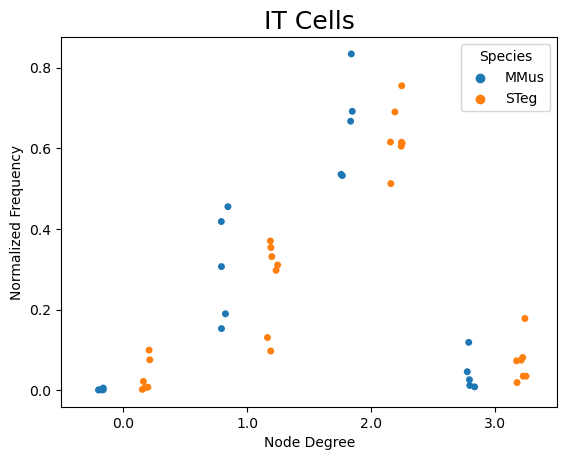

In [17]:
plot = pd.concat([mm_it_nodes, st_it_nodes])
sns.stripplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", dodge=True)
plt.title("IT Cells", size=18)

Text(0.5, 1.0, 'PT Cells')

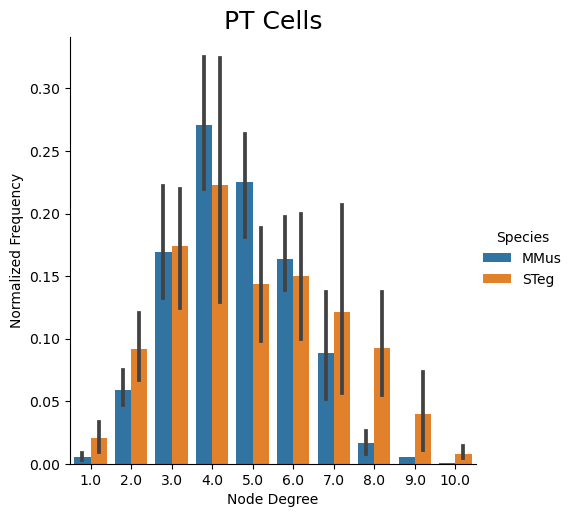

In [14]:
plot = pd.concat([mm_pt_nodes, st_pt_nodes])
sns.catplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", kind="bar")
plt.title("PT Cells", size=18)

Text(0.5, 1.0, 'PT Cells')

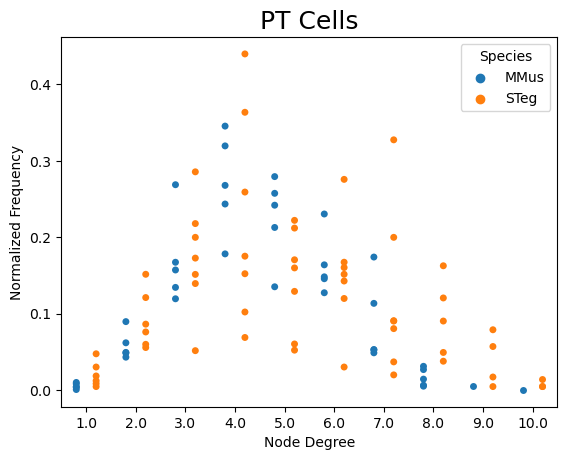

In [19]:
plot = pd.concat([mm_pt_nodes, st_pt_nodes])
sns.stripplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", dodge=True, jitter=False)
plt.title("PT Cells", size=18)

# Look at AUD neurons

In [20]:
# seperate AUD neurons

aud_it_mm = []
for i in range(len(omc_it_mm)):
    aud_idx = omc_it_mm[i]["AUD"] == 1
    aud_it_mm.append(omc_it_mm[i][aud_idx])

aud_it_st = []
for i in range(len(omc_it_st)):
    aud_idx = omc_it_st[i]["AUD"] == 1
    aud_it_st.append(omc_it_st[i][aud_idx])

aud_pt_mm = []
for i in range(len(omc_pt_mm)):
    aud_idx = omc_pt_mm[i]["AUD"] == 1
    aud_pt_mm.append(omc_pt_mm[i][aud_idx])

aud_pt_st = []
for i in range(len(omc_pt_st)):
    aud_idx = omc_pt_st[i]["AUD"] == 1
    aud_pt_st.append(omc_pt_st[i][aud_idx])

In [22]:
# calculate degrees for aud cells
aud_mm_it_nodes = df_to_nodes(aud_it_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
aud_st_it_nodes = df_to_nodes(aud_it_st, drop=["OMCi"], mice=mice_st, species="STeg")
aud_mm_pt_nodes = df_to_nodes(aud_pt_mm, drop=["OMCi"], mice=mice_mm, species="MMus")
aud_st_pt_nodes = df_to_nodes(aud_pt_st, drop=["OMCi"], mice=mice_st, species="STeg")

Text(0.5, 1.0, 'AUD IT Cells')

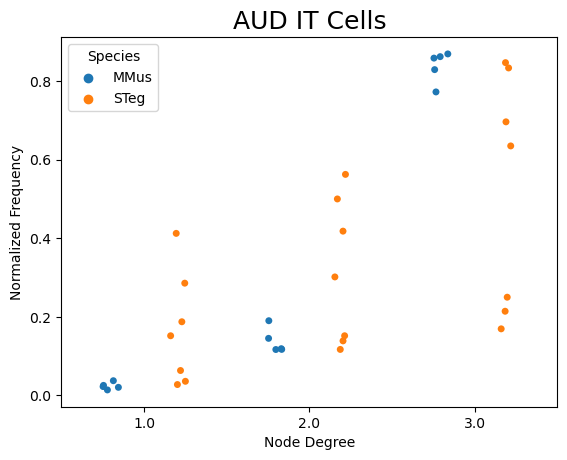

In [23]:
# make dot plots for degrees
plot = pd.concat([aud_mm_it_nodes, aud_st_it_nodes])
sns.stripplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", dodge=True)
plt.title("AUD IT Cells", size=18)

Text(0.5, 1.0, 'AUD PT Cells')

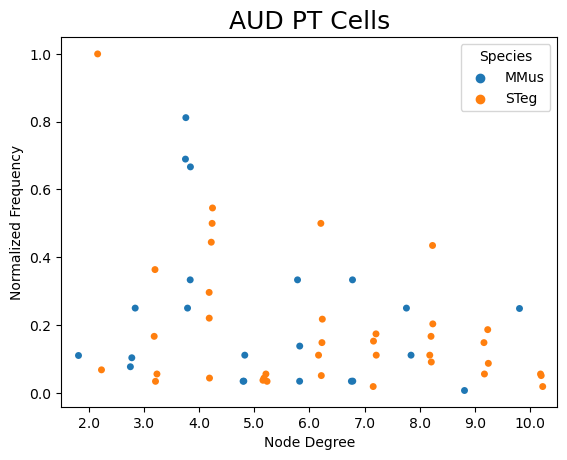

In [24]:
# make dot plots for degrees
plot = pd.concat([aud_mm_pt_nodes, aud_st_pt_nodes])
sns.stripplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", dodge=True)
plt.title("AUD PT Cells", size=18)